In [7]:
import numpy as np
import math
from numba import njit, jit
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rescale


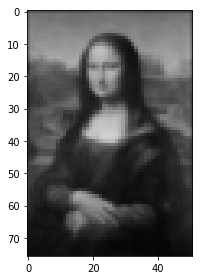

In [2]:
raw_image = io.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1024px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg")
#raw_image = io.imread("https://s.yimg.jp/images/top/sp2/cmn/logo-170307.png")
grayimage = rgb2gray(raw_image)
image = rescale(grayimage, 1.0 / 20.0, anti_aliasing=True, multichannel=False, mode='constant')
io.imshow(image, cmap='gray')

In [3]:
@njit
def genIr(h, w):
    return np.random.rand(h,w)

@njit
def getBr(Ir, T):
    return np.dot(Ir.ravel(), T.ravel()) / ( T.shape[0] * T.shape[1] )

@njit
def updateTgi(Tgi, Ir, Br, BrMean):
    coeff = Br - BrMean
    Tgi += Ir * coeff

@njit
def ghostImagingOnline(M, T):
    preM = 100000 # Brの平均を求めるために計算する回数
    BrsMeanHat = 0.0
    for idx in range(preM):
        Ir = genIr(T.shape[0],T.shape[1])
        Br = getBr(Ir, T)
        BrsMeanHat += Br
    BrsMeanHat /= preM

    Tgi = np.zeros(T.shape)
    for idx in range(M):
        Ir = genIr(T.shape[0],T.shape[1])
        Br = getBr(Ir, T)
        updateTgi(Tgi, Ir, Br, BrsMeanHat)
    return Tgi


CPU times: user 2.47 s, sys: 8.21 ms, total: 2.48 s
Wall time: 2.48 s


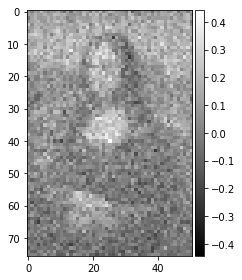

In [4]:
%%time
# Low memory consumption algorithm.
gi = ghostImagingOnline(M=20000, T=image)

io.imshow(gi, cmap='gray')


In [5]:
@njit
def genIrs(n, h, w):
    return np.random.rand(n,h,w)

@njit
def getBrs(Irs, T):
    brs = np.zeros(len(Irs))
    for idx in range(len(Irs)):
        brs[idx] = getBr(Irs[idx], T)
    return brs

@njit
def getTgi(Irs, Brs):
    coeffs = Brs - Brs.mean()
    Tgi = np.zeros((Irs.shape[1], Irs.shape[2]))
    for idx in range(len(Brs)):
        Tgi += Irs[idx] * coeffs[idx]
    return Tgi

@njit
def ghostImaging(M, T):
    Irs = genIrs(M, *T.shape)
    Brs = getBrs(Irs, T)
    Tgi = getTgi(Irs, Brs)
    return Tgi


CPU times: user 1.01 s, sys: 95.8 ms, total: 1.11 s
Wall time: 1.1 s


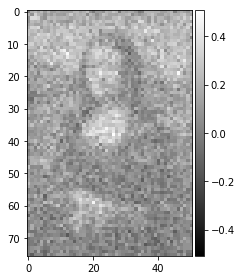

In [6]:
%%time
# Straight implementation but huge memory consumption due to all random images are stored in 'Irs'. 
gi = ghostImaging(M=20000,T=image)

io.imshow(gi, cmap='gray')